In [4]:
%%capture
%pip install -U 'rockfish[labs]' -f 'https://packages.rockfish.ai'

In [5]:
import io
import rockfish as rf
import rockfish.actions as ra
import rockfish.labs

### Amplify on selected field from tabular data


In [6]:
tabular_data = b"""\
Age range of patient,Sex,BBS Score,Heart Rate
60<70,M,41,80
30<40,F,41,78
60<70,M,43,81
80<90,M,40,82
60<70,M,40,90
60<70,M,38,90
20<30,M,38,70
1<13,F,38,75
70<80,M,38,70
40<50,F,38,80
80<90,M,42,88
40<50,F,42,89
60<70,M,42,90
80<90,M,42,101
70<80,M,42,100
80<90,F,42,101
60<70,M,39,99
1<13,F,39,98
80<90,M,39,75
70<80,M,39,74
"""

In [7]:
# connect locally
conn = rf.Connection.local()

In [8]:
tab_dataset = rf.Dataset.from_csv(
    "Before_amplified", io.BytesIO(tabular_data)
)
tab_dataset.to_pandas()

,Age range of patient,Sex,BBS Score,Heart Rate
0,60<70,M,41,80
1,30<40,F,41,78
2,60<70,M,43,81
3,80<90,M,40,82
4,60<70,M,40,90
5,60<70,M,38,90
6,20<30,M,38,70
7,1<13,F,38,75
8,70<80,M,38,70
9,40<50,F,38,80


In [9]:
# dropping records in column "Sex" other than the value of "M" by given percentage
post_amplify = ra.PostAmplify(
    {
        "query_ast": {
            "eq": ["Sex", "M"],
        },
        "drop_match_percentage": 0.0,
        "drop_other_percentage": 0.7,
    }
)

save_amplified = ra.DatasetSave({"name": "After_amplified"})
builder = rf.WorkflowBuilder()
builder.add_dataset(tab_dataset)
builder.add_action(post_amplify, parents=[tab_dataset])
builder.add_action(save_amplified, parents=[post_amplify])
workflow = await builder.start(conn)

In [10]:
async for progress in workflow.progress("post-amplify"):
    print(progress)

2024-12-13T02:49:19.808376Z post-amplify:   0%
2024-12-13T02:49:19.948863Z post-amplify:  50%
2024-12-13T02:49:19.949331Z post-amplify: 100%


In [11]:
amplified_tab_dataset = None
async for sds in workflow.datasets():
    amplified_tab_dataset = await sds.to_local(conn)
amplified_tab_dataset.to_pandas()

,Age range of patient,Sex,BBS Score,Heart Rate
0,60<70,M,41,80
1,60<70,M,43,81
2,80<90,M,40,82
3,60<70,M,40,90
4,60<70,M,38,90
5,20<30,M,38,70
6,70<80,M,38,70
7,80<90,M,42,88
8,60<70,M,42,90
9,80<90,M,42,101


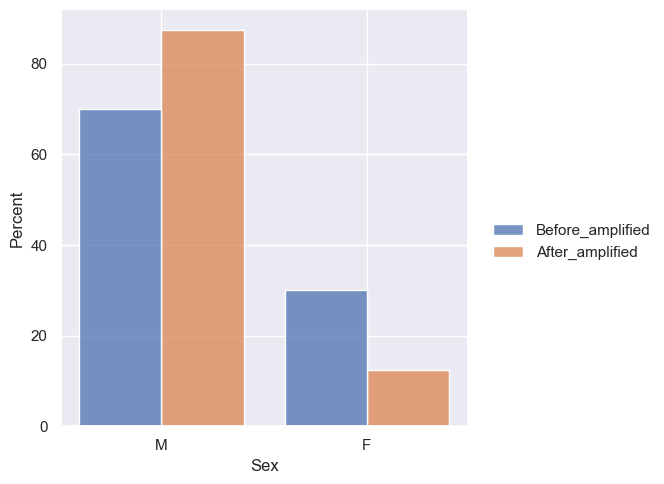

In [12]:
# before vs after amplifying the condition: Sex == "M"
col = "Sex"
before_tab_agg = rf.metrics.count_all(tab_dataset, col)
after_tab_agg = rf.metrics.count_all(amplified_tab_dataset, col)
rf.labs.vis.plot_bar([before_tab_agg, after_tab_agg], col, f"{col}_count")